In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import csv
import numpy as np
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/breast-cancer.csv')
print(df.shape)
print(df.columns)
print(df.describe())


(569, 32)
Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     

<Axes: >

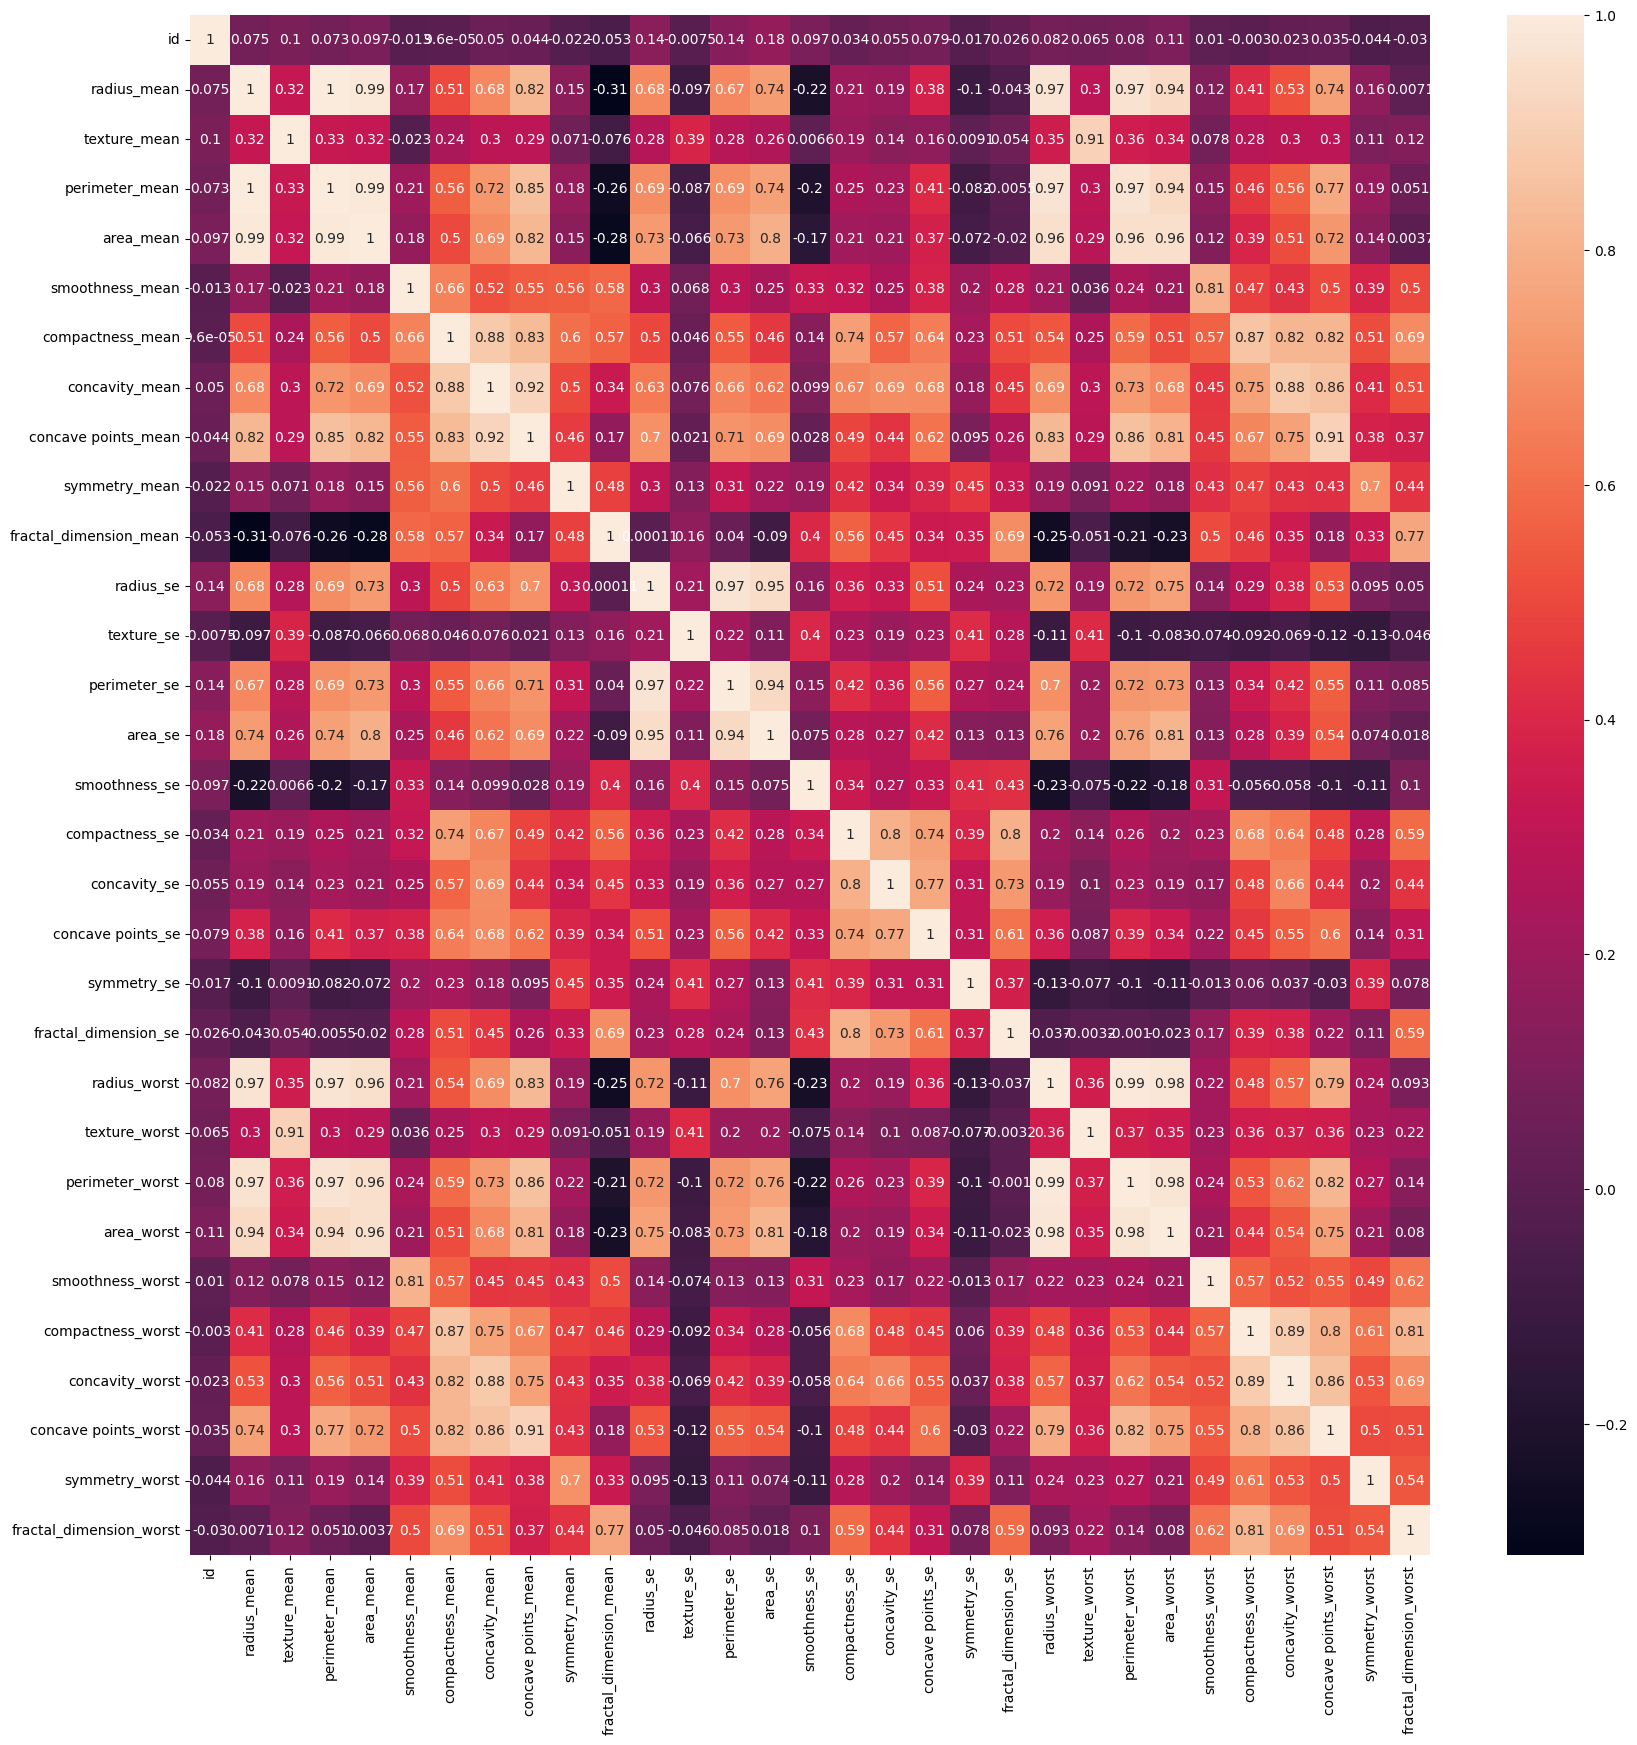

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(numeric_only=True),annot=True)

In [ ]:
class Node():
  def __init__(self, feature = None, threshold = None, child_left = None, child_right = None, value = None):
    self.feature = feature
    self.threshold = threshold
    self.child_left = child_left
    self.child_right = child_right
    self.value = value

class DecisionTree():
  def __init__(self, max_depth, min_sample):
    self.max_depth = max_depth
    self.min_sample = min_sample

  def split_data(self, dataset, feature, threshold):
    set_left = dataset[dataset[:, feature] <= threshold]
    set_right = dataset[dataset[:, feature] > threshold]
    return set_left, set_right

  def entropy(self, label):
    entropy = 0
    values = np.unique(label)
    for value in values:
      p = len(label[label == value]) / len(label)
      entropy -= p * np.log2(p)
    return entropy

  def best_split(self, data):
    best_split = {'gain': -1,'feature': None, 'threshold': None}
    cur = self.entropy(data[:, -1])
    columns = data.shape[1]
    for i in range(columns-1):
      thresholds = np.unique(data[:, i])
      for threshold in thresholds:
        set_left, set_right = self.split_data(data, i, threshold)
        if  len(set_left) and len(set_right):
          gain = cur - self.entropy(set_left[:, -1]) - self.entropy(set_right[:, -1])
          if gain > best_split['gain']:
            best_split['gain'] = gain
            best_split['threshold'] = threshold
            best_split['feature'] = i
    # if best_split['threshold'] and  best_split['feature'] is None:
    #   print("Wr split", data)
    return best_split

  def leaf_value(self, data):
    unique, counts = np.unique(data[:, -1], return_counts=True)
    return unique[0]

  def build(self, data, depth):

    if len(data) >= self.min_sample and depth <= self.max_depth:
      best_split = self.best_split(data)
      if best_split['feature'] is None:
        return Node(value=self.leaf_value(data))
      set_left, set_right = self.split_data(data, best_split['feature'], best_split['threshold'])
      if best_split['threshold'] and len(set_left) and len(set_right):
        child_left = self.build(set_left, depth+1)
        child_right = self.build(set_right, depth+1)
        if child_left.value is None and child_left.feature is None:
          print("Invalid child left")
        if child_right.value is None and child_right.feature is None:
          print("Invalid child right")
        return Node(best_split['feature'], best_split['threshold'], child_left, child_right)
    value = self.leaf_value(data)
    return Node(value=value)

  def fit(self, X, y):
    data = np.concatenate((X, y), axis=1)
    self.root = self.build(data, 0)

  def make_prediction(self, x, node):
    if node.value is not None:
        return node.value
    else:
      feature = x[node.feature]
      if node.threshold:
        if feature <= node.threshold:
            return self.make_prediction(x, node.child_left)
        else:
            return self.make_prediction(x, node.child_right)

  def predict(self, X):
      predictions = []
      X = np.array(X)
      for i in range(X.shape[0]):
        x = X[i, :]
        prediction = self.make_prediction(x, self.root)
        predictions.append(prediction)
      np.array(predictions)
      return predictions

In [ ]:
def train_test_split(X, y, random_state=41, test_size=0.2):
    n_samples = X.shape[0]
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(np.arange(n_samples))
    test_size = int(n_samples * test_size)

    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]

    X_train, X_test = X.loc[train_indices], X.loc[test_indices]
    y_train, y_test = y.loc[train_indices], y.loc[test_indices]
    return X_train, X_test, y_train, y_test

y = pd.DataFrame(df['diagnosis'])
X = df.drop(['diagnosis'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape)

(456, 31) (456, 1)


In [ ]:
model = DecisionTree(100, 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 0.9824561403508771
Test accuracy: 0.9380530973451328


In [ ]:
import math
class RandomForest:
    def __init__(self, trees, n_trees, max_feature ,
                 prediction_aggrigation_calculation):
        self.n_estimators = n_trees
        self.max_features = max_feature
        self.tree_feature_indexes = []
        self.prediction_aggrigation_calculation = prediction_aggrigation_calculation
        self.trees = trees

    def _make_random_suset(self, X, y, n_subsets, replasment=True):
        subset = []
        sample_size = (X.shape[0] if replasment else (X.shape[0] // 2))
        Xy = np.concatenate((X, y), axis=1)
        np.random.shuffle(Xy)
        for i in range(n_subsets):
            index = np.random.choice(range(sample_size), size=np.shape(range(sample_size)), replace=replasment)
            X = Xy[index][:, :-1]
            y = Xy[index][: , -1]
            subset.append({"X" : X, "y": y})
        return subset

    def train(self, X, y):
        n_features = X.shape[1]
        if self.max_features == None:
            self.max_features = int(math.sqrt(n_features))
        subsets = self._make_random_suset(X, y, self.n_estimators)

        for i, subset in enumerate(subsets):
            X_subset , y_subset = subset["X"], subset["y"]
            idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
            self.tree_feature_indexes.append(idx)
            X_subset = X_subset[:, idx]
            y_subset = np.expand_dims(y_subset, axis =1)
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, test_X):
        y_preds = np.empty((test_X.shape[0], self.n_estimators))
        # print(self.max_features, test_X.shape[1])
        test_X = np.array(test_X)

        labels = {}
        index = []
        for i, tree in enumerate(self.trees):
            features_index = self.tree_feature_indexes[i]
            X_selected_features = test_X[:, features_index]
            y_pred = np.array(tree.predict(X_selected_features))
            # print(y_pred)
            unique, counts = np.unique(y_pred, return_counts=True)
            for label in unique:
              if label not in labels.keys():
                labels[label] = len(index)
                index.append(label)
            y_pred = np.array([labels[x] for x in y_pred])
            for j in range(test_X.shape[0]):
              y_preds[j][i] = y_pred[j]
        y_pred = self.prediction_aggrigation_calculation(y_preds)
        # print(y_pred, index)
        y_pred = np.round(y_pred, decimals= 0).astype(int)
        return [index[x[0]] for x in y_pred]

class RandomForestClassifier(RandomForest):
    def __init__(self, max_feature, max_depth, n_trees=100, min_sample_split=2, min_impurity=1e-7):
        self.prediction_aggrigation_calculation = self._maximum_vote_calculation
        self.trees = []
        for _ in range(n_trees):
            self.trees.append(DecisionTree(max_depth, min_sample_split))

        super().__init__(trees=self.trees, n_trees=n_trees,max_feature=max_feature,
                         prediction_aggrigation_calculation=self.prediction_aggrigation_calculation)

    def _maximum_vote_calculation(self, y_preds):
        # create a empty array to store the prediction.
        y_pred = np.empty((y_preds.shape[0], 1))
        # iterate over all the data samples.
        for i, sample_predictions in enumerate(y_preds):
            y_pred[i] = np.bincount(sample_predictions.astype('int')).argmax()

        return y_pred
model = RandomForestClassifier(3, 100, 5)
model.train(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 0.9605263157894737
Test accuracy: 0.9292035398230089


In [ ]:
model = DecisionTree(100, 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 0.9824561403508771
Test accuracy: 0.9380530973451328


In [ ]:
model = DecisionTree(3000, 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 1.0
Test accuracy: 0.9292035398230089


In [ ]:
bad_feature = ['concave points_worst', 'area_mean', 'area_se', 'perimeter_worst', 'concave points_mean', 'texture_worst', 'perimeter_se', 'area_worst', 'radius_worst', 'concavity_worst', 'perimeter_mean']
df_new = df.drop(bad_feature, axis=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 1.0
Test accuracy: 0.9292035398230089


In [ ]:
y = pd.DataFrame(df_new['diagnosis'])
X = df_new.drop(['diagnosis'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

(456, 20) (456, 1)
Train accuracy: 1.0
Test accuracy: 0.8495575221238938


In [ ]:
model = DecisionTree(3000, 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 1.0
Test accuracy: 0.8495575221238938


In [ ]:
model = DecisionTree(1000, 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 1.0
Test accuracy: 0.8495575221238938


In [ ]:
model = DecisionTree(100, 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 0.9122807017543859
Test accuracy: 0.8584070796460177


In [ ]:
df['diagnosis'].value_counts()
df['diagnosis'] = np.where(df['diagnosis'] == 'M', 1, 0)
print(df['diagnosis'])


0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64


In [ ]:
info = df.corr()['diagnosis']
print(info)
new_columns = info[abs(info) > 0.1].keys()
# print(new_columns)
new_df = df[new_columns]
print(len(new_df.columns))

id                         0.039769
diagnosis                  1.000000
radius_mean                0.730029
texture_mean               0.415185
perimeter_mean             0.742636
area_mean                  0.708984
smoothness_mean            0.358560
compactness_mean           0.596534
concavity_mean             0.696360
concave points_mean        0.776614
symmetry_mean              0.330499
fractal_dimension_mean    -0.012838
radius_se                  0.567134
texture_se                -0.008303
perimeter_se               0.556141
area_se                    0.548236
smoothness_se             -0.067016
compactness_se             0.292999
concavity_se               0.253730
concave points_se          0.408042
symmetry_se               -0.006522
fractal_dimension_se       0.077972
radius_worst               0.776454
texture_worst              0.456903
perimeter_worst            0.782914
area_worst                 0.733825
smoothness_worst           0.421465
compactness_worst          0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[new_columns], pd.DataFrame(y))

In [ ]:
print(X_train.shape, y_train.shape)
model = DecisionTree(100, 10)
model.fit(X_train, y_train)
# print(X_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

(456, 26) (456, 1)
Train accuracy: 0.6228070175438597
Test accuracy: 0.6460176991150443


In [ ]:
model = RandomForestClassifier(9, 100, 10)
model.train(X_train, y_train)
y_pred = model.predict(X_train)
print("Train accuracy:", (y_train.to_numpy().reshape(1, X_train.shape[0])[0] == y_pred).sum() / len(y_pred))
y_pred = model.predict(X_test)
print("Test accuracy:", (y_test.to_numpy().reshape(1, X_test.shape[0])[0] == y_pred).sum() / len(y_pred))

Train accuracy: 0.9517543859649122
Test accuracy: 0.9557522123893806
